# New York Citi Bike Analysis

This notebook contains some data exploration and model building using New York city's open source bike ridership data:
https://www.citibikenyc.com/system-data

In [2]:
# Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import geopy.distance
from sklearn.cross_validation import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import math
import datetime
import folium
from collections import namedtuple

### Importing data

In [2]:
# Finding files
path = os.getcwd() + '/Data'
files = os.listdir(path)

# Picking out csv files
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv = sorted(files_csv)

# Loop over list of files and append
data_12 = pd.DataFrame()

for f in files_csv:
    print(f)
    data = pd.read_csv(path + '/' + f)
    data.columns = ['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
                    'Start Station Name', 'Start Station Latitude', 'Start Station Longitude',
                    'End Station ID', 'End Station Name', 'End Station Latitude',
                    'End Station Longitude', 'Bike ID', 'User Type', 'Birth Year', 'Gender']
    #print(data.columns.values)
    data_12 = data_12.append(data)

201701-citibike-tripdata.csv
201702-citibike-tripdata.csv
201703-citibike-tripdata.csv
201704-citibike-tripdata.csv
201705-citibike-tripdata.csv
201706-citibike-tripdata.csv
201707-citibike-tripdata.csv
201708-citibike-tripdata.csv
201709-citibike-tripdata.csv
201710-citibike-tripdata.csv
201711-citibike-tripdata.csv
201712-citibike-tripdata.csv


Trip Duration           Start Time            Stop Time  Start Station ID  \
0            680  2017-01-01 00:00:21  2017-01-01 00:11:41              3226   
1           1282  2017-01-01 00:00:45  2017-01-01 00:22:08              3263   
2            648  2017-01-01 00:00:57  2017-01-01 00:11:46              3143   
3            631  2017-01-01 00:01:10  2017-01-01 00:11:42              3143   
4            621  2017-01-01 00:01:25  2017-01-01 00:11:47              3143   

            Start Station Name  Start Station Latitude  \
0  W 82 St & Central Park West               40.782750   
1       Cooper Square & E 7 St               40.729236   
2              5 Ave & E 78 St               40.776829   
3              5 Ave & E 78 St               40.776829   
4              5 Ave & E 78 St               40.776829   

   Start Station Longitude  End Station ID             End Station Name  \
0               -73.971370            3165  Central Park West & W 72 St   
1               -73.990868             498           Broadway & W 32 St   
2               -73.963888            3152              3 Ave & E 71 St   
3               -73.963888            3152              3 Ave & E 71 St   
4               -73.963888            3152              3 Ave & E 71 St   

   End Station Latitude  End Station Longitude  Bike ID   User Type  \
0             40.775794             -73.976206    25542  Subscriber   
1             40.748549             -73.988084    21136  Subscriber   
2             40.768737             -73.961199    18147    Customer   
3             40.768737             -73.961199    21211    Customer   
4             40.768737             -73.961199    26819    Customer   

   Birth Year  Gender  
0      1965.0       2  
1      1987.0       2  
2         NaN       0  
3         NaN       0  
4         NaN       0

In [3]:
data_12.describe()

Trip Duration  Start Station ID  Start Station Latitude  \
count   1.636466e+07      1.636466e+07            1.636466e+07   
mean    9.945862e+02      1.357132e+03            4.073663e+01   
std     1.617892e+04      1.346904e+03            7.262269e-02   
min     6.100000e+01      7.200000e+01            0.000000e+00   
25%     3.720000e+02      3.610000e+02            4.071871e+01   
50%     6.210000e+02      4.870000e+02            4.073782e+01   
75%     1.076000e+03      3.142000e+03            4.075594e+01   
max     9.735948e+06      3.654000e+03            4.550636e+01   

       Start Station Longitude  End Station ID  End Station Latitude  \
count             1.636466e+07    1.636466e+07          1.636466e+07   
mean             -7.398450e+01    1.349138e+03          4.073638e+01   
std               1.211708e-01    1.344688e+03          5.225299e-02   
min              -7.403423e+01    7.200000e+01          0.000000e+00   
25%              -7.399662e+01    3.590000e+02          4.071850e+01   
50%              -7.398752e+01    4.860000e+02          4.073705e+01   
75%              -7.397606e+01    3.141000e+03          4.075514e+01   
max               0.000000e+00    3.654000e+03          4.550636e+01   

       End Station Longitude       Bike ID    Birth Year        Gender  
count           1.636466e+07  1.636466e+07  1.473432e+07  1.636466e+07  
mean           -7.398481e+01  2.375463e+04  1.978895e+03  1.123459e+00  
std             7.950876e-02  5.345616e+03  1.183019e+01  5.615377e-01  
min            -7.408585e+01  1.452900e+04  1.858000e+03  0.000000e+00  
25%            -7.399704e+01  1.865300e+04  1.971000e+03  1.000000e+00  
50%            -7.398759e+01  2.546400e+04  1.982000e+03  1.000000e+00  
75%            -7.397621e+01  2.811400e+04  1.988000e+03  1.000000e+00  
max             0.000000e+00  3.348100e+04  2.001000e+03  2.000000e+00

There are over 16 million rows in the data. In order to run code on my local system, I have randomly sampled 100,000 rows and used the sample for further analysis.

In [4]:
# Sampling 100,000k rows for code development
data_100k = data_12.sample(100000, random_state = 1)
#data_100k.to_csv('Data12_sample.csv')

In [2]:
# Loading data back in for easy future processing
sample = pd.read_csv('/Users/arjun.varma/Documents/Project work/DevUp/Capstone/Data12_sample.csv')
sample = sample.drop('Unnamed: 0', 1)

### Exploratory Data Analysis
Basic EDA using visualizations, descriptive statistics and correlations was carried get to get an overall sense of the data and identify outliers/anomalies

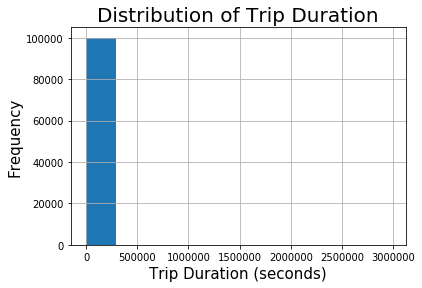

In [3]:
# Looking at trip duration distribution
sample['Trip Duration'].hist()
plt.xlabel("Trip Duration (seconds)",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title('Distribution of Trip Duration',fontsize=20)

##### Takeaway
Majority of trip durations are under 10,000 seconds but there are some trips that range into unreasonable times (might have to filter them out)

In [4]:
# Looking at completeness of data
sample.describe(include = 'all')

Trip Duration           Start Time            Stop Time  \
count    1.000000e+05               100000               100000   
unique            NaN                99695                99693   
top               NaN  2017-06-05 17:50:38  2017-09-11 17:19:43   
freq              NaN                    3                    2   
mean     1.012068e+03                  NaN                  NaN   
std      1.513114e+04                  NaN                  NaN   
min      6.100000e+01                  NaN                  NaN   
25%      3.730000e+02                  NaN                  NaN   
50%      6.250000e+02                  NaN                  NaN   
75%      1.079000e+03                  NaN                  NaN   
max      2.973441e+06                  NaN                  NaN   

        Start Station ID     Start Station Name  Start Station Latitude  \
count      100000.000000                 100000           100000.000000   
unique               NaN                    786                     NaN   
top                  NaN  Pershing Square North                     NaN   
freq                 NaN                   1042                     NaN   
mean         1357.655780                    NaN               40.736605   
std          1347.016732                    NaN                0.028238   
min            72.000000                    NaN               40.646538   
25%           360.000000                    NaN               40.718794   
50%           487.000000                    NaN               40.737262   
75%          3142.000000                    NaN               40.755273   
max          3649.000000                    NaN               40.814394   

        Start Station Longitude  End Station ID       End Station Name  \
count             100000.000000    100000.00000                 100000   
unique                      NaN             NaN                    789   
top                         NaN             NaN  Pershing Square North   
freq                        NaN             NaN                    993   
mean                 -73.984727      1346.90004                    NaN   
std                    0.017311      1343.23404                    NaN   
min                  -74.025353        72.00000                    NaN   
25%                  -73.996621       361.00000                    NaN   
50%                  -73.987520       486.00000                    NaN   
75%                  -73.976056      3140.00000                    NaN   
max                  -73.907744      3649.00000                    NaN   

        End Station Latitude  End Station Longitude       Bike ID   User Type  \
count          100000.000000          100000.000000  100000.00000       99910   
unique                   NaN                    NaN           NaN           2   
top                      NaN                    NaN           NaN  Subscriber   
freq                     NaN                    NaN           NaN       89064   
mean               40.736359             -73.984897   23752.52380         NaN   
std                 0.028083               0.017363    5338.89384         NaN   
min                40.646538             -74.049638   14529.00000         NaN   
25%                40.717821             -73.997044   18636.00000         NaN   
50%                40.737050             -73.987654   25470.00000         NaN   
75%                40.755136             -73.976206   28099.00000         NaN   
max                40.814394             -73.907744   33473.00000         NaN   

          Birth Year         Gender  
count   89995.000000  100000.000000  
unique           NaN            NaN  
top              NaN            NaN  
freq             NaN            NaN  
mean     1978.897794       1.122680  
std        11.820210       0.562328  
min      1885.000000       0.000000  
25%      1971.000000       1.000000  
50%      1982.000000       1.000000  
75%      1988.000000       1.000000  
max      2001.000000  

##### Takeaway
Most of the columns look clean with complete data but User Type and Age have some missing values which may need to be imputed

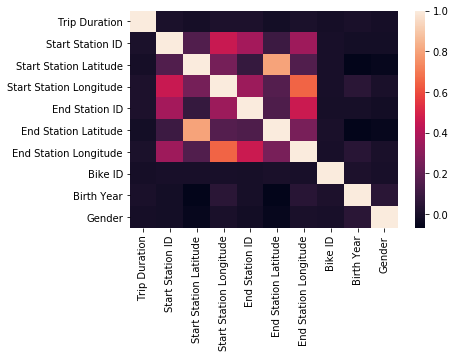

In [5]:
# Looking at the correlation matrix of the data
corr = sample.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

##### Takeaway
None of the columns have a direct correlation with the trip duration meaning we might have to resort to a combination of features (present and derived) and obtain additional data to create a good model

### Data pre-processing
The data preprocessing tasks carried out were filtering out outliers, renaming columns to an understandable format, imputing missing values and getting derived features for modeling  

In [6]:
# Function to get day of the week from a date
def calculate_dayofweek(row):
    dt = str(row['Date'])
    year, month, day = (int(x) for x in dt.split()[0].split('-')) 
    ans = datetime.date(year, month, day)
    return ans.strftime("%A")

# Haversine distance
def calculate_distance(row):
    return geopy.distance.vincenty((row['Start Station Latitude'],row['Start Station Longitude']),
                                   (row['End Station Latitude'],row['End Station Longitude'])).miles

# get_arrows and get_bearings to plot arrows on folium map
def get_arrows(locations, color='blue', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation).add_to(m2))
    return arrows

def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

In [7]:
modeling_data = sample.copy()

# Filtering out trips lasting longer than 12 hours
modeling_data = modeling_data[modeling_data['Trip Duration'] <= 43200]

# Calculating distance and speed
modeling_data['Trip_Distance_miles'] = modeling_data.apply(calculate_distance,axis = 1)
modeling_data['Speed_mph'] = modeling_data['Trip_Distance_miles'] / (modeling_data['Trip Duration']/(60*60))

# Gender modifications
modeling_data.loc[modeling_data.Gender == 1, 'Gender'] = 'Male'
modeling_data.loc[modeling_data.Gender == 2, 'Gender'] = 'Female'
modeling_data.loc[modeling_data.Gender == 0, 'Gender'] = 'Unknown'

# Age - imputing using gender mean and capping at 90 years
modeling_data['Age'] = 2017 - modeling_data['Birth Year']
modeling_data["Age"].fillna(modeling_data.groupby("Gender")["Age"].transform("mean"), inplace=True)
modeling_data.loc[modeling_data.Age >= 90, 'Age'] = 90

# User type
modeling_data['User Type'] = modeling_data['User Type'].fillna('Unknown')

# Transforming y variable to take care of long tail
#modeling_data['Trip Duration'] = np.log(modeling_data['Trip Duration'])

# OTHER DERIVED FEATURES
modeling_data['Date'] = modeling_data['Start Time'].astype(str).str[:10] # for joining
modeling_data['Hour'] = modeling_data['Start Time'].astype(str).str[11:13]
modeling_data['DayOfWeek'] = modeling_data.apply(calculate_dayofweek,axis = 1)
modeling_data[:5]

Trip Duration           Start Time            Stop Time  Start Station ID  \
0            528  2017-06-05 21:04:12  2017-06-05 21:13:01               545   
1            780  2017-05-26 19:21:52  2017-05-26 19:34:53              3256   
2            734  2017-11-05 16:58:02  2017-11-05 17:10:16               280   
3            990  2017-03-25 09:01:05  2017-03-25 09:17:35              2012   
4            234  2017-06-22 19:46:21  2017-06-22 19:50:15              3137   

            Start Station Name  Start Station Latitude  \
0              E 23 St & 1 Ave               40.736502   
1  Pier 40 - Hudson River Park               40.727714   
2              E 10 St & 5 Ave               40.733320   
3              E 27 St & 1 Ave               40.739445   
4              5 Ave & E 73 St               40.772828   

   Start Station Longitude  End Station ID          End Station Name  \
0               -73.978095            3428           8 Ave & W 16 St   
1               -74.011296             315  South St & Gouverneur Ln   
2               -73.995101             459          W 20 St & 11 Ave   
3               -73.976806            3141           1 Ave & E 68 St   
4               -73.966853            3438           E 76 St & 3 Ave   

   End Station Latitude    ...     Bike ID   User Type Birth Year  Gender  \
0             40.740983    ...       26438  Subscriber     1992.0    Male   
1             40.703554    ...       18897  Subscriber     1975.0  Female   
2             40.746745    ...       25888  Subscriber     1987.0  Female   
3             40.765005    ...       21318  Subscriber     1968.0  Female   
4             40.772249    ...       28694  Subscriber     1962.0    Male   

  Trip_Distance_miles  Speed_mph   Age        Date Hour DayOfWeek  
0            1.277028   8.707006  25.0  2017-06-05   21    Monday  
1            1.684471   7.774480  42.0  2017-05-26   19    Friday  
2            1.139870   5.590645  30.0  2017-11-05   16    Sunday  
3            2.016313   7.332048  49.0  2017-03-25   09  Saturday  
4            0.444104   6.832366  55.0  2017-06-22   19  Thursday  

[5 rows x 21 columns]

### 1)	Top 5 stations with the most starts (showing # of starts)

In [8]:
# Aggregating starts by station
start_stations = modeling_data.groupby(['Start Station ID','Start Station Name','Start Station Latitude',
                                 'Start Station Longitude'])[['Trip Duration']].count().sort_values(['Trip Duration'],ascending=False).reset_index()
start_stations.columns = ['Start Station ID','Start Station Name','Start Station Latitude','Start Station Longitude','Starts']
start_stations = start_stations[:5]

# Visualization
start_stations[:5]

Start Station ID     Start Station Name  Start Station Latitude  \
0               519  Pershing Square North               40.751873   
1               497     E 17 St & Broadway               40.737050   
2               435        W 21 St & 6 Ave               40.741740   
3               402     Broadway & E 22 St               40.740343   
4               426  West St & Chambers St               40.717548   

   Start Station Longitude  Starts  
0               -73.977706    1042  
1               -73.990093     702  
2               -73.994156     662  
3               -73.989551     636  
4               -74.013221     613

In [9]:
# Plotting on a map
# Make an empty map
m = folium.Map([40.731873, -73.987706], tiles="Stamen Toner", zoom_start=13)
 
# I can add marker one by one on the map    
for i in range(0,len(start_stations)):
    folium.Marker([start_stations.iloc[i]['Start Station Latitude'],start_stations.iloc[i]['Start Station Longitude']],
                  popup=folium.Popup(start_stations.iloc[i]['Start Station Name'])
                 ).add_to(m)
    folium.Circle(
      location=[start_stations.iloc[i]['Start Station Latitude'],start_stations.iloc[i]['Start Station Longitude']],
      popup=start_stations.iloc[i]['Start Station Name'],
      radius=start_stations.iloc[i]['Starts'].tolist()/2,
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)

m

### 2)	Trip duration by user type

User Type  Average Duration  Median Duration
0    Customer       1630.220527           1290.0
1  Subscriber        753.680540            575.0
2     Unknown       1194.722222           1111.5

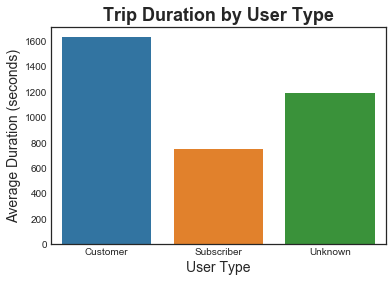

In [10]:
# Aggregating trip duration based on user type
user_dur = modeling_data.groupby('User Type').agg({'Trip Duration':['mean','median']}).reset_index()
user_dur.columns = ['User Type','Average Duration','Median Duration']

# Visualization
#user_dur.plot(kind = 'bar', x= 'User Type', y = 'Average Duration')
sns.set_style("white")
b = sns.barplot(x = "User Type", y = "Average Duration", data = user_dur)
b.set_title("Trip Duration by User Type", weight='bold').set_fontsize('18')
b.set_xlabel('User Type',fontsize=14)
b.set_ylabel('Average Duration (seconds)',fontsize=14)
user_dur

### 3)	Most popular trips based on start station and stop station

In [32]:
# Creating start stop variables
start_stop = modeling_data.copy()
start_stop['Start Stop Name'] = start_stop['Start Station Name'] + ' to ' + start_stop['End Station Name']
start_stop['Start Stop ID'] = start_stop['Start Station ID'].map(str) + ' to ' + start_stop['End Station ID'].map(str)

# Finding popular trips
popular_trips = start_stop.groupby(['Start Stop Name','Start Stop ID','Start Station Latitude','Start Station Longitude',
                                    'End Station Latitude','End Station Longitude'])[['Trip Duration']].count().sort_values(['Trip Duration'],ascending=False).reset_index()
popular_trips.columns = ['Start Stop Name','Start Stop ID','Start Station Latitude','Start Station Longitude',
                                    'End Station Latitude','End Station Longitude','Count']
popular_trips = popular_trips[:5]
popular_trips

Start Stop Name Start Stop ID  \
0       Central Park S & 6 Ave to 5 Ave & E 88 St  2006 to 3282   
1     E 7 St & Avenue A to Cooper Square & E 7 St   432 to 3263   
2       12 Ave & W 40 St to West St & Chambers St    514 to 426   
3     Pershing Square North to Broadway & W 32 St    519 to 498   
4  Little West St & 1 Pl to West St & Chambers St   2008 to 426   

   Start Station Latitude  Start Station Longitude  End Station Latitude  \
0               40.765909               -73.976342             40.783070   
1               40.726218               -73.983799             40.729236   
2               40.760875               -74.002777             40.717548   
3               40.751873               -73.977706             40.748549   
4               40.705693               -74.016777             40.717548   

   End Station Longitude  Count  
0             -73.959390     43  
1             -73.990868     39  
2             -74.013221     35  
3             -73.988084     35  
4             -74.013221     32

In [33]:
# Plotting on a map

# Make an empty map
m2 = folium.Map([40.731873, -73.987706], tiles="Stamen Toner", zoom_start=12)
 
# I can add marker one by one on the map    
for i in range(0,len(start_stations)):
    folium.Marker([popular_trips.iloc[i]['Start Station Latitude'],popular_trips.iloc[i]['Start Station Longitude']],
                  popup=popular_trips.iloc[i]['Start Stop Name'].split('to')[0]).add_to(m2)
    folium.Marker([popular_trips.iloc[i]['End Station Latitude'],popular_trips.iloc[i]['End Station Longitude']],
                  popup=popular_trips.iloc[i]['Start Stop Name'].split('to')[1]).add_to(m2)
    
    p1 = [popular_trips.iloc[i]['Start Station Latitude'],popular_trips.iloc[i]['Start Station Longitude']]
    p2 = [popular_trips.iloc[i]['End Station Latitude'],popular_trips.iloc[i]['End Station Longitude']]
    
    folium.PolyLine(locations=[p1, p2], color='red').add_to(m2)
    
    arrows = get_arrows(locations=[p1, p2], n_arrows=2)
    for arrow in arrows:
        arrow.add_to(m2)

m2

### 4)	Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled/trip duration)

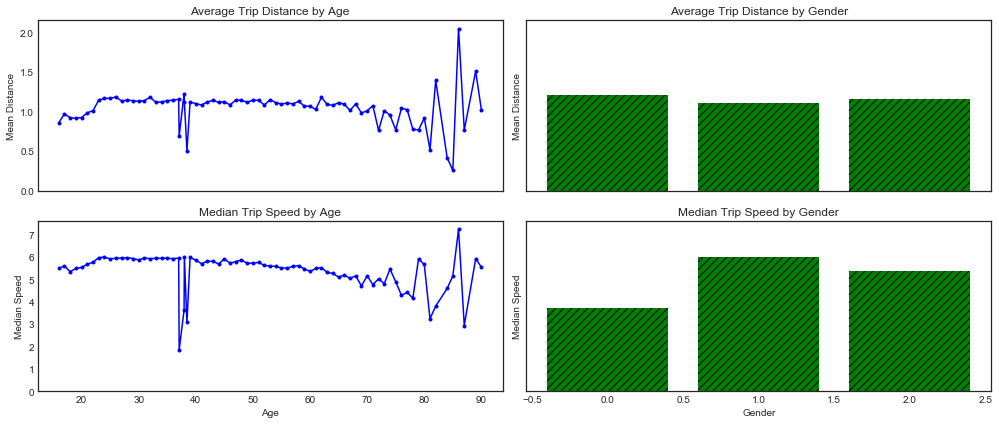

In [14]:
# Calculating metrics
age_perf = modeling_data.groupby('Age').agg({'Trip_Distance_miles':['mean'], 
                         'Speed_mph':'median'}).reset_index()
age_perf.columns = ['Age','Mean Distance','Median Speed']

gender_perf = modeling_data.groupby('Gender').agg({'Trip_Distance_miles':['mean'], 
                         'Speed_mph':'median'}).reset_index()
gender_perf.columns = ['Gender','Mean Distance','Median Speed']

# Renaming for convinience
gender_perf.loc[gender_perf.Gender == 'Male', 'Gender'] = 1
gender_perf.loc[gender_perf.Gender == 'Female', 'Gender'] = 2
gender_perf.loc[gender_perf.Gender == 'Unknown', 'Gender'] = 0

# First, create a blank figure and "axis" objects
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row',figsize=(14, 6))

# Each "axis" object corresponds to one subplot
# Fill in the subplots.
ax1.plot(age_perf['Age'], age_perf['Mean Distance'], color='blue', marker='.')
ax1.set_title('Average Trip Distance by Age')
ax1.set_ylabel('Mean Distance')

ax2.bar(gender_perf['Gender'], gender_perf['Mean Distance'], color='green', hatch='///')
ax2.set_title('Average Trip Distance by Gender')
ax2.set_ylabel('Mean Distance')

ax3.plot(age_perf['Age'], age_perf['Median Speed'], color='blue', marker='.')
ax3.set_title('Median Trip Speed by Age')
ax3.set_ylabel('Median Speed')
ax3.set_xlabel('Age')

ax4.bar(gender_perf['Gender'], gender_perf['Median Speed'], color='green', hatch='///')
ax4.set_title('Median Trip Speed by Gender')
ax4.set_ylabel('Median Speed')
ax4.set_xlabel('Gender')

fig.tight_layout()

### 5) What is the busiest bike in NYC in 2017? How many times was it used? How many minutes was it in use?

In [15]:
# Aggregation by Bike ID
busy_bike = modeling_data.groupby('Bike ID').agg({'Trip_Distance_miles':['count'], 
                         'Trip Duration':'sum'}).reset_index()
busy_bike.columns = ['Bike ID','Times Used','Seconds In Use']
busy_bike_mins = busy_bike.sort_values(['Seconds In Use', 'Times Used'], ascending=[False, False])
busy_bike_timesused = busy_bike.sort_values(['Times Used', 'Seconds In Use'], ascending=[False, False])

# Displaying in a table
display(busy_bike_mins[:5])
display(busy_bike_timesused[:5])

Bike ID  Times Used  Seconds In Use
4075    19564           8           49205
7067    26004          14           47692
6532    25457          10           47124
6066    24974          12           45642
876     15641           8           45338

Bike ID  Times Used  Seconds In Use
8040    27161          24           19119
6909    25839          24           15729
6978    25910          23           19743
6759    25687          23           19367
6588    25516          22           27638

# Predictive modeling

### Getting additional data - Weather

In [17]:
# Weather Data
weather_data = pd.read_csv("/Users/arjun.varma/Documents/Project work/DevUp/Capstone/Weather Data.csv")

# Keeping only required columns and renaming
weather_data = weather_data[['DATE','AWND','PRCP','SNOW','TMAX','TMIN','WT01','WT02','WT03','WT04','WT06','WT08']]
weather_data.columns = ['Date','avg_wind_speed','precipitation','snow','temp_max','temp_min',
                        'ind_fog','ind_heavy_fog','ind_thunder','ind_pellets','ind_glaze','ind_smoke']
weather_data['temp_avg'] = (weather_data['temp_max'] + weather_data['temp_min']) / 2

# Filling NaNs and converting into integers
weather_data = weather_data.fillna(0)
cols = ['ind_fog','ind_heavy_fog','ind_thunder','ind_pellets','ind_glaze','ind_smoke']
weather_data[cols] = weather_data[cols].applymap(np.int64)
#weather_data[["Date"]] = weather_data[["Date"]].astype(str) 

weather_data[:5]

Date  avg_wind_speed  precipitation  snow  temp_max  temp_min  \
0  2017-01-01            5.59           0.00   0.0        48        40   
1  2017-01-02            9.17           0.21   0.0        41        37   
2  2017-01-03           10.74           0.58   0.0        43        39   
3  2017-01-04            8.05           0.00   0.0        52        34   
4  2017-01-05            7.83           0.00   0.0        34        27   

   ind_fog  ind_heavy_fog  ind_thunder  ind_pellets  ind_glaze  ind_smoke  \
0        0              0            0            0          0          1   
1        1              0            0            1          0          0   
2        1              0            0            0          0          0   
3        1              0            0            0          0          1   
4        0              0            0            0          0          0   

   temp_avg  
0      44.0  
1      39.0  
2      41.0  
3      43.0  
4      30.5

In [18]:
# Merging back to original dataset
modeling_data_w = pd.merge(modeling_data, weather_data, how='inner', on=['Date'])
print(modeling_data_w.columns.values)
modeling_data_w[:5]

['Trip Duration' 'Start Time' 'Stop Time' 'Start Station ID'
 'Start Station Name' 'Start Station Latitude' 'Start Station Longitude'
 'End Station ID' 'End Station Name' 'End Station Latitude'
 'End Station Longitude' 'Bike ID' 'User Type' 'Birth Year' 'Gender'
 'Trip_Distance_miles' 'Speed_mph' 'Age' 'Date' 'Hour' 'DayOfWeek'
 'avg_wind_speed' 'precipitation' 'snow' 'temp_max' 'temp_min' 'ind_fog'
 'ind_heavy_fog' 'ind_thunder' 'ind_pellets' 'ind_glaze' 'ind_smoke'
 'temp_avg']


Trip Duration           Start Time            Stop Time  Start Station ID  \
0            528  2017-06-05 21:04:12  2017-06-05 21:13:01               545   
1            269  2017-06-05 08:12:30  2017-06-05 08:17:00              3263   
2            576  2017-06-05 18:21:28  2017-06-05 18:31:04              3167   
3            742  2017-06-05 18:13:30  2017-06-05 18:25:53               523   
4            873  2017-06-05 11:30:08  2017-06-05 11:44:42               377   

        Start Station Name  Start Station Latitude  Start Station Longitude  \
0          E 23 St & 1 Ave               40.736502               -73.978095   
1   Cooper Square & E 7 St               40.729236               -73.990868   
2  Amsterdam Ave & W 73 St               40.779668               -73.980930   
3          W 38 St & 8 Ave               40.754666               -73.991382   
4         6 Ave & Canal St               40.722438               -74.005664   

   End Station ID              End Station Name  End Station Latitude  \
0            3428               8 Ave & W 16 St             40.740983   
1             252  MacDougal St & Washington Sq             40.732264   
2            3295      Central Park W & W 96 St             40.791270   
3             164               E 47 St & 2 Ave             40.753231   
4             491          E 24 St & Park Ave S             40.740964   

    ...     snow  temp_max temp_min  ind_fog ind_heavy_fog  ind_thunder  \
0   ...      0.0        67       58        1             0            0   
1   ...      0.0        67       58        1             0            0   
2   ...      0.0        67       58        1             0            0   
3   ...      0.0        67       58        1             0            0   
4   ...      0.0        67       58        1             0            0   

   ind_pellets  ind_glaze ind_smoke temp_avg  
0            0          0         1     62.5  
1            0          0         1     62.5  
2            0          0         1     62.5  
3            0          0         1     62.5  
4            0          0         1     62.5  

[5 rows x 33 columns]

In [19]:
# SETTING UP TRAIN AND TEST SPLITS

# Selecting features for modeling
X = modeling_data_w[['Trip_Distance_miles','User Type','Gender','Hour','DayOfWeek', 'avg_wind_speed',
                   'precipitation', 'snow', 'ind_fog', 'ind_heavy_fog', 'ind_thunder', 
                   'ind_pellets', 'ind_glaze', 'ind_smoke', 'temp_avg']]

# Dummies for categorical variables
X = pd.get_dummies(X, columns = ['User Type','Gender','Hour','DayOfWeek'])
y = modeling_data_w['Trip Duration']

# Splitting into 2/3 train and 1/3 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

In [34]:
pd.set_option('display.max_columns', None)
X_train[:5]

Trip_Distance_miles  avg_wind_speed  precipitation  snow  ind_fog  \
62642             0.868666            4.47           0.03   0.0        0   
87651             1.422398            6.71           0.00   0.0        0   
46237             0.719541            6.26           0.00   0.0        0   
30146             1.035460            3.36           0.00   0.0        0   
34315             0.812841            5.14           0.30   0.0        1   

       ind_heavy_fog  ind_thunder  ind_pellets  ind_glaze  ind_smoke  \
62642              0            0            0          0          0   
87651              0            0            0          0          0   
46237              0            0            0          0          0   
30146              0            0            0          0          1   
34315              0            0            0          0          1   

       temp_avg  User Type_Customer  User Type_Subscriber  User Type_Unknown  \
62642      45.5                   0                     1                  0   
87651      66.0                   0                     1                  0   
46237      78.5                   0                     1                  0   
30146      47.0                   0                     1                  0   
34315      80.5                   0                     1                  0   

       Gender_Female  Gender_Male  Gender_Unknown  Hour_00  Hour_01  Hour_02  \
62642              0            1               0        0        0        0   
87651              1            0               0        0        0        0   
46237              0            1               0        1        0        0   
30146              0            1               0        0        0        0   
34315              0            1               0        0        0        0   

       Hour_03  Hour_04  Hour_05  Hour_06  Hour_07  Hour_08  Hour_09  Hour_10  \
62642        0        0        0        0        0        1        0        0   
87651        0        0        0        0        0        1        0        0   
46237        0        0        0        0        0        0        0        0   
30146        0        0        0        0        0        0        0        0   
34315        0        0        0        0        0        0        1        0   

       Hour_11  Hour_12  Hour_13  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  \
62642        0        0        0        0        0        0        0        0   
87651        0        0        0        0        0        0        0        0   
46237        0        0        0        0        0        0        0        0   
30146        0        0        0        0        1        0        0        0   
34315        0        0        0        0        0        0        0        0   

       Hour_19  Hour_20  Hour_21  Hour_22  Hour_23  DayOfWeek_Friday  \
62642        0        0        0        0        0                 0   
87651        0        0        0        0        0                 0   
46237        0        0        0        0        0                 1   
30146        0        0        0        0        0                 0   
34315        0        0        0        0        0                 0   

       DayOfWeek_Monday  DayOfWeek_Saturday  DayOfWeek_Sunday  \
62642                 0                   0                 0   
87651                 1                   0                 0   
46237                 0                   0                 0   
30146                 0                   0                 0   
34315                 0                   0                 0   

       DayOfWeek_Thursday  DayOfWeek_Tuesday  DayOfWeek_Wednesday  
62642                   1                  0                    0  
87651                   0                  0                    0  
46237                   0                  0                    0  
30146                   1                  0                    0  
34315            

### Linear Regression

In [21]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_lr = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_lr)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred_lr))

Coefficients: 
 [  4.64653265e+02  -6.92550011e-01  -2.67510459e+01   1.09555773e+01
  -2.45860950e+00   4.90713789e+01   2.84217094e-13  -1.23428249e+02
  -8.95901727e+01   3.76938816e+00   1.85810616e+00   3.73529241e+02
  -3.72464127e+02  -1.06511439e+00   1.95116196e+01  -4.85933172e+01
   2.90816977e+01  -9.39744079e+01  -6.66733268e+01   6.44743748e+01
   2.12886347e+02   2.07945000e+01  -6.87780939e+01  -1.31576138e+02
  -8.73055477e+01  -4.46274489e+01  -3.28761801e+01   3.80686867e+01
   3.25408585e+01   4.05917128e+01   6.13054601e+01   4.64366358e+01
   5.72584487e+01   3.21027303e+01  -7.44993631e+00  -1.35296742e+01
  -2.28420400e+01   2.66555920e+00   2.31070989e+01  -3.30536911e+00
  -5.92942496e+01  -1.03604342e+01  -2.22704362e+01   2.14431541e+01
   6.08417462e+01  -1.89187149e+01  -1.17201983e+01  -1.90151167e+01]
Root Mean squared error: 775.43
Variance score: 0.28


### Lasso Regression

In [22]:
# Getting best alpha
lassocv = LassoCV(cv=3, normalize = True)
lassocv.fit(X_train, y_train)
print ("Best Alpha from lasso: " + str(lassocv.alpha_) + '\n')

# Predicting on test
y_pred_lasso = lassocv.predict(X_test)

# The coefficients
print('Coefficients: \n', lassocv.coef_)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_lasso)))

Best Alpha from lasso: 0.0185717297832

Coefficients: 
 [  4.58624592e+02  -1.52546037e-01  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   1.56791905e+00   3.92589291e+02
  -3.58187292e+02   0.00000000e+00   0.00000000e+00  -6.35255747e+01
   4.37231469e+00  -3.82735771e+01  -0.00000000e+00   0.00000000e+00
   9.08495594e+01   0.00000000e+00  -9.77177177e+00  -1.00598786e+02
  -6.55183522e+01  -2.87629625e+01  -1.38721046e+01   1.75707538e+01
   1.34640181e+01   2.26057658e+01   4.35601626e+01   2.94377861e+01
   4.07044448e+01   1.63438606e+01  -0.00000000e+00  -0.00000000e+00
  -4.41609112e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -1.79145063e+01   0.00000000e+00  -0.00000000e+00   2.75761414e+01
   6.94087574e+01  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00]
Root Mean squared error: 775.37


### SVM Regressor

In [23]:
# Setting up regressor
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

# Predicting on test
y_pred_svr = svr.predict(X_test)

# The coefficients
print('Coefficients: \n', svr.coef_)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_svr)))

Coefficients: 
 [[  5.09228100e+02  -3.30111084e-01  -7.22316962e+00   4.81056836e+00
   -9.99639122e-01   3.40352246e+00   0.00000000e+00  -5.34026272e+00
    1.00000000e+00  -1.60995292e+00   4.99655306e-01   1.92663237e+02
   -2.15663237e+02   2.30000000e+01   1.71577214e+01  -4.14606967e+01
    2.43029753e+01  -2.34992208e+01  -1.61506737e+01  -5.05109069e+00
   -1.40000000e+01  -1.21859416e+01  -4.78211055e+01  -4.92089377e+01
   -3.43063291e+01  -8.84969699e+00  -2.12760167e+00   1.56623565e+01
    1.82937374e+01   1.97249411e+01   2.74461693e+01   3.63622113e+01
    3.26350199e+01   2.22786687e+01   1.71794268e+01   1.10281513e+01
    1.00608890e+01   8.42001772e+00   3.97411789e+00  -3.65936793e+00
   -6.20574113e+00  -2.19641541e+00  -9.15771669e+00   1.45560458e+01
    9.16542636e+00  -4.14068219e+00  -3.59826256e+00  -4.62839529e+00]]
Root Mean squared error: 792.03


### Random Forest

In [24]:
# Setting up regressor
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

# Predicting on test
y_pred_rf = regr.predict(X_test)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_rf)))

Root Mean squared error: 898.43


In [747]:
# Parameter optimization
parameters = {'n_estimators':[10,50,100,200], 'min_samples_leaf':[1,5,10,50,100], 'max_features': ('auto','sqrt') } 
              
gridsearch = GridSearchCV(regr,parameters)

gridsearch.fit(X_train, y_train)

# Predicting on test
y_pred_rf_opti = gridsearch.predict(X_test)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_rf)))

print("Root Mean squared error optimized: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_rf_opti)))

Root Mean squared error: 878.64
Root Mean squared error optimized: 763.23


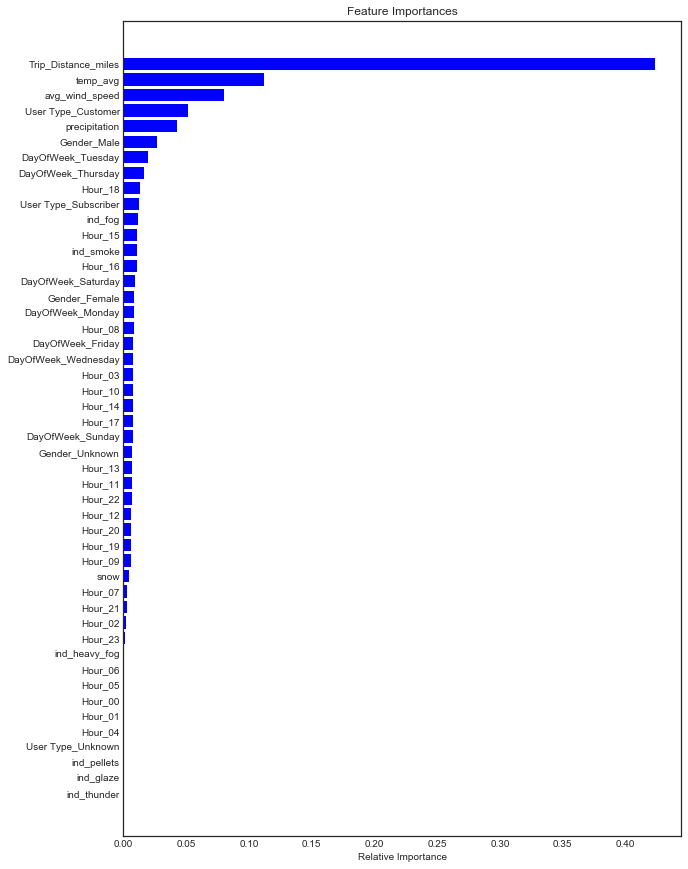

In [94]:
# Looking at important features
plt.figure(figsize=(10,15))
importances = regr.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

As anticipated, the distance between the two locations is the most important variable in predicting time taken. Temperature, wind speed and precipitation are the most important waether related features

### Gradient Boost

In [25]:
# Setting up regressor
clf = ensemble.GradientBoostingRegressor()
clf.fit(X_train, y_train)

# Predicting on test
y_pred_gbm = clf.predict(X_test)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_gbm)))

Root Mean squared error: 762.17


In [26]:
# Parameter optimization
parameters = {'learning_rate':[0.01,0.05,0.1], 'min_samples_split':[2,5,10,20], 'min_samples_leaf':[1,2,5,10], \
               'max_depth':[1,2,3], 'max_features': [1,2,3,4,5] } 
              
gridsearch = GridSearchCV(clf,parameters)

gridsearch.fit(X_train, y_train)

# Predicting on test
y_pred_gbm_opti = gridsearch.predict(X_test)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_gbm)))

print("Root Mean squared error optimized: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_gbm_opti)))

Root Mean squared error: 762.17
Root Mean squared error optimized: 768.89


### Neural Network - Multi layer Perceptron

In [27]:
# Setting up regressor
mlp = MLPRegressor(hidden_layer_sizes = (500,), max_iter = 500)
mlp.fit(X_train, y_train)

# Predicting on test
y_pred_mlp = mlp.predict(X_test)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_mlp)))

Root Mean squared error: 774.16


In [28]:
# Parameter optimization
parameters = {'solver':('lbfgs','sgd'), 'activation':('logistic','tanh'), 'alpha':[0.1,0.01,0.001] } 
              
gridsearch = GridSearchCV(mlp,parameters)

gridsearch.fit(X_train, y_train)

# Predicting on test
y_pred_mlp_opti = gridsearch.predict(X_test)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_mlp)))

print("Root Mean squared error optimized: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred_mlp_opti)))

Root Mean squared error: 774.16
Root Mean squared error optimized: 777.98


The best peforming model was the GBM with as RMSE of about 762 seconds. Some of the parameter optimizations did not improve the base model since not enough paramters were fed into the GridSearch algorithm (computing power limitation). Distance, temperature, wind speed and user type are the strongest predictors of trip duration

### Error analysis of best model

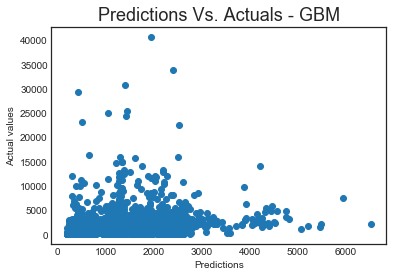

In [29]:
# Checking actual vs predicted
plt.scatter(y_pred_gbm, y_test)
plt.ylabel('Actual values')
plt.xlabel('Predictions')
plt.title('Predictions Vs. Actuals - GBM',fontsize=18)

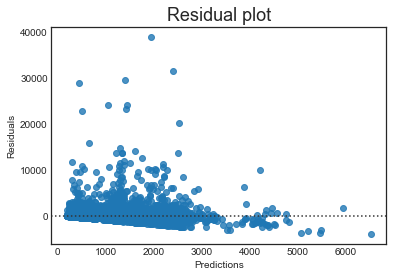

In [30]:
# Checking residuals
ax = sns.residplot(y_pred_gbm,(y_test - y_pred_gbm))
ax.set_title('Residual plot',fontsize=18)
ax.set_xlabel('Predictions')
ax.set_ylabel('Residuals')

The model performs quite well but struggles to predict some trips with extremely long durations (drives RMSE up since these points are heavily weighted). More extensive parameter optimization, further limiting max trip duration and trying ensemble models are some ways in which this could be reduced